In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

C:\Users\User\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from ema_workbench import load_results
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, 
                           ema_logging, Constant, Scenario, Policy, CategoricalParameter, IntegerParameter,
                           perform_experiments, SequentialEvaluator, Constraint)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.util import ema_logging, utilities
import time
from problem_formulation import get_model_for_problem_formulation
#from signal import signal, SIGPIPE, SIG_DFL
#signal(SIGPIPE, SIG_DFL)
import pickle

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [3]:
results = pd.read_csv("results/results_reevaluation.csv")

In [4]:
results.drop(['Unnamed: 0'], axis=1, inplace=True)

In [5]:
results

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model,All Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths
0,76,262.700608,10.0,0.640277,141.966071,1.5,0.206812,180.506684,1.0,0.385086,...,1,2,0,4,dikesnet,9.537893e+08,0.000000,0.000000e+00,5.397251e+07,0.000000
1,106,306.403307,1.0,0.525580,126.403024,10.0,0.132563,178.796506,1.0,0.513056,...,1,2,1,4,dikesnet,9.537893e+08,0.000000,0.000000e+00,5.397251e+07,0.000000
2,97,209.753324,1.5,0.408170,308.826473,10.0,0.314795,270.550638,1.0,0.197602,...,1,2,2,4,dikesnet,9.537893e+08,0.000000,0.000000e+00,5.397251e+07,0.000000
3,53,240.358920,10.0,0.939596,49.019791,1.5,0.434024,247.644907,1.0,0.964298,...,1,2,3,4,dikesnet,9.537893e+08,0.000000,0.000000e+00,5.397251e+07,0.000000
4,8,305.469762,10.0,0.312076,96.172885,1.0,0.751104,345.582450,1.5,0.304617,...,1,2,4,4,dikesnet,9.537893e+08,0.000000,0.000000e+00,5.397251e+07,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,121,177.066954,1.5,0.352684,95.321026,1.5,0.690870,341.099764,10.0,0.258666,...,2,3,995,33,dikesnet,4.912596e+08,0.000000,0.000000e+00,3.725520e+07,0.000000
7996,48,272.273384,1.0,0.375960,47.997302,1.0,0.054370,287.737349,10.0,0.171085,...,2,3,996,33,dikesnet,5.020538e+08,0.001039,0.000000e+00,3.725520e+07,0.000000
7997,70,221.377266,10.0,0.849412,264.339809,1.5,0.612174,180.926475,1.5,0.043990,...,2,3,997,33,dikesnet,4.912596e+08,0.000000,0.000000e+00,3.725520e+07,0.000000
7998,40,155.103737,1.5,0.062811,77.309677,10.0,0.470226,292.422968,1.0,0.254511,...,2,3,998,33,dikesnet,8.670009e+08,0.049281,3.589998e+08,3.725520e+07,0.047613


### Robustness metrics

In this phase we evaluate the robustness of the set of policies. Different robustness metrics capture different aspects and trade-offs of the policies. Moreover, preferences of policy makers might change over time, so it is essential to use various metrics. We have included the following metrics:


Firstly, we define the functions

In [6]:
def s_to_n(data):
    mean = np.mean(data)
    std = np.std(data)
    
    return mean*std

In [7]:
with open('results/results_reevaluation.pickle', 'rb') as f:
     results = pickle.load(f)

In [8]:
experiments, outcomes = results

In [9]:
list_keys = []
for key in outcomes:
    list_keys.append(key)
    

In [10]:
list_keys

['All Costs',
 'Expected Number of Deaths',
 'A.1_Expected Annual Damage',
 'A.1_Dike Investment Costs',
 'A.1_Expected Number of Deaths']

In [21]:
len(outcomes["All Costs"])

8000

In [11]:
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in list_keys:
        value  = outcomes[outcome][logical]
        sn_ratio = s_to_n(value)
        scores[outcome] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,All Costs,Expected Number of Deaths,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths
11,1.898724e+17,0.000077,2.951005e+15,0.315096,1.736162e-05
15,1.973243e+17,0.000124,3.212375e+15,0.000000,1.922196e-05
21,1.596221e+17,0.000117,7.812584e+15,0.356495,7.890071e-05
23,1.065574e+17,0.000038,2.737089e+15,0.000000,1.583709e-05
27,4.613675e+17,0.001346,1.838116e+17,0.315096,1.266157e-03
33,3.317308e+17,0.000756,7.104748e+16,0.277573,7.170017e-04
4,3.056283e+16,0.000002,4.604064e+10,0.000000,2.743839e-10
9,1.680349e+17,0.000017,2.737089e+15,0.000000,1.583709e-05


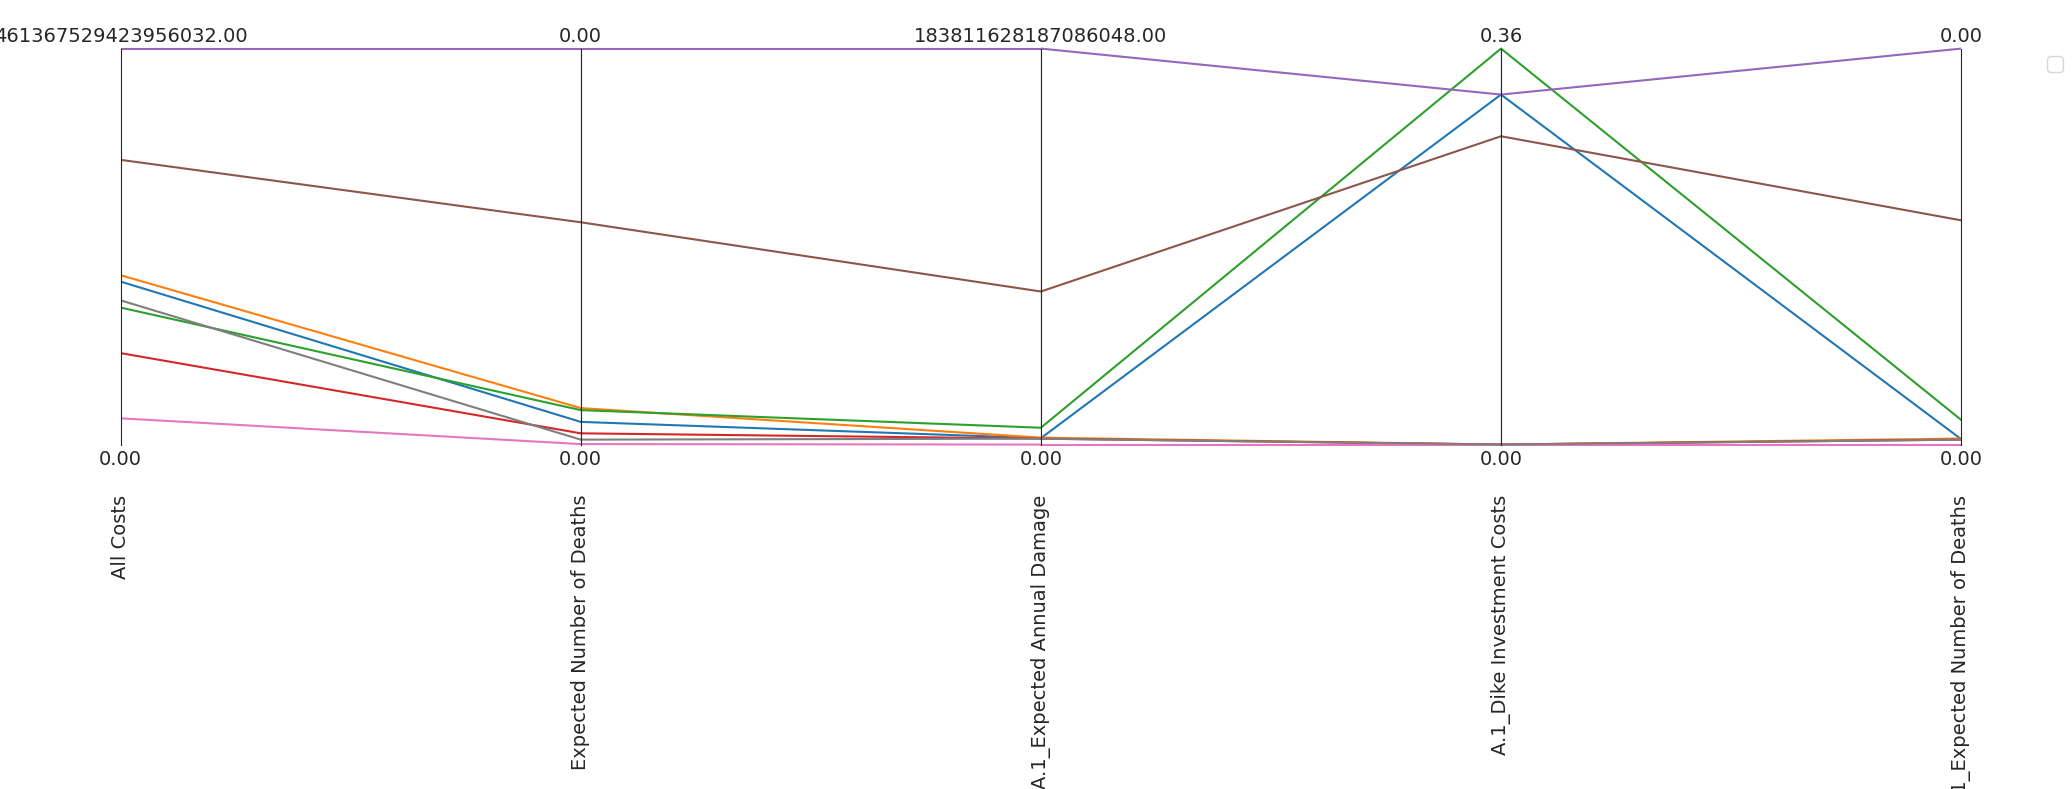

In [23]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)
limits.loc[0, list(data.columns)] = 0
axes = parcoords.ParallelAxes(limits)

axes.plot(data)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["figure.figsize"] = (20,8)

axes.legend()
plt.show()

#f = plt.savefig("visualization/trade-offs.png")

In [13]:
def calculate_regret(data, best):
    return np.abs(best-data)